# Analysis of Planning Results

Here we explore the performance of the different planning algorithms across the different environments.

For each algorithm we will look at their mean performance (i.e. episode returns) across the different environments. Looking at both in-distribution (planning population matches the test population) and out-of-distribution (planning population does not match the test population) settings.

**Note** some algorithms, namely I-NTMCP and POMCP, have no planning population. I-NTMCP and POMCP model the other agent as an I-POMDP and uniform random, respectively. Thus, we only consider the out-of-distribution setting for these algorithms, looking at their performance against the various populations (`P0` and `P1`).

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from posggym_baselines.config import REPO_DIR

sys.path.insert(0, str(REPO_DIR / "baseline_exps"))
import exp_utils

sns.set_theme()
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

SAVE_RESULTS = False

In [2]:
ALL_ENV_DATA = exp_utils.load_all_env_data()
for k in ALL_ENV_DATA:
    print(k)

NUM_ENVS = len(ALL_ENV_DATA)

# figure parameters
FIGSIZE = (10, 10)
N_COLS = min(3, NUM_ENVS)
N_ROWS = (NUM_ENVS // N_COLS) + int(NUM_ENVS % N_COLS > 0)

CooperativeReaching-v0
Driving-v1
LevelBasedForaging-v3
PredatorPrey-v0
PursuitEvasion-v1_i0
PursuitEvasion-v1_i1


## Load Planning Results

In [19]:
planning_results = []
for env_id, env_data in ALL_ENV_DATA.items():
    env_planning_results = pd.read_csv(env_data.planning_results_file)
    env_planning_results["full_env_id"] = env_id
    planning_results.append(env_planning_results)

planning_results_df = pd.concat(planning_results, ignore_index=True)
planning_results_df.rename(
    columns={
        "planning_pop_id": "Planning Population",
        "test_pop_id": "Test Population",
        "return": "Return",
    },
    inplace=True,
)

# Add In/Out of Distribution labels
def get_in_out_dist_label(row):
    return row["Planning Population"] == row["Test Population"]

planning_results_df["In Distribution"] = planning_results_df.apply(
    get_in_out_dist_label, axis=1
)

planning_results_df.sort_values(
    by=["alg", "full_env_id", "Planning Population", "Test Population", "search_time_limit"], 
    inplace=True
)

max_search_time = planning_results_df["search_time_limit"].max()

# Can remove this once we have all the data
# planning_results_df = planning_results_df[planning_results_df["search_time_limit"] > 0.05]
planning_results_df = planning_results_df[
    (planning_results_df["alg"] == "POTMMCP") &
    (planning_results_df["full_env_id"] != "LevelBasedForaging-v3") &
    (planning_results_df["full_env_id"] != "PursuitEvasion-v1_i0")
]
print(planning_results_df["search_time_limit"].unique())

[ 0.1  1.   5.  10.  20. ]


## Planning Algorithm Performance against Planning and Test Populations

Dimensions:

- Environment
- Algorithm
- Planning Population
- Test Population
- Search Time

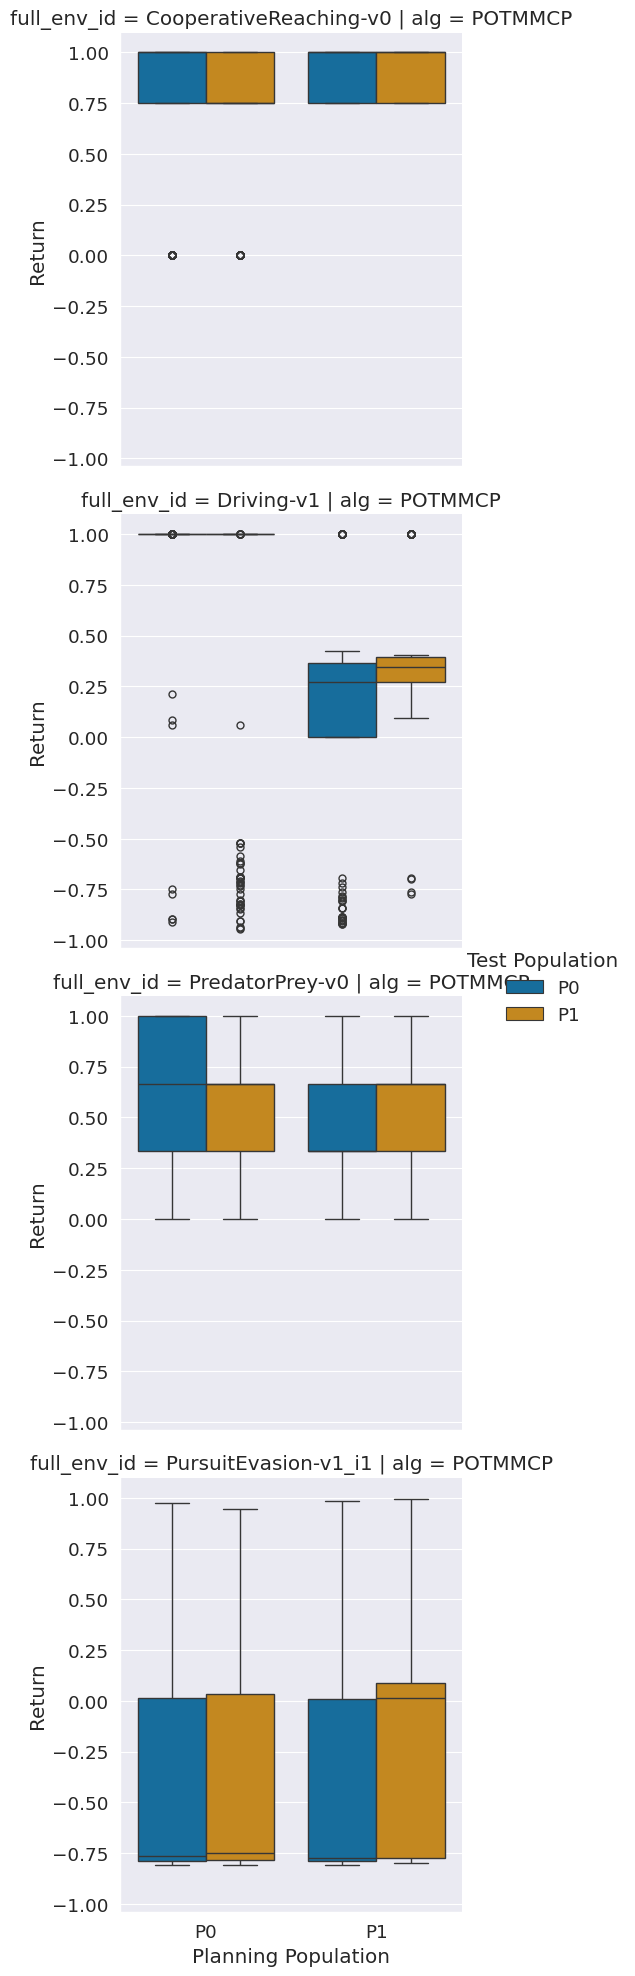

In [20]:
plot = sns.catplot(
    data=planning_results_df[
        planning_results_df["search_time_limit"] == max_search_time
    ],
    x="Planning Population",
    y="Return",
    hue="Test Population",
    col="alg",
    # col_wrap=N_COLS,
    row="full_env_id",
    kind="box",
    sharey=True,
)

if SAVE_RESULTS:
    plot.figure.savefig(
        exp_utils.ENV_DATA_DIR / "all_env_planning_max_search_results.png"
        bbox_inches="tight"
    )

del plot

## In vs Out of Distribution Performance by Environment

Here we look at the in-distribution vs out-of-distribution performance of the different algorithms for each environment given the maximum search time.

- `x-axis`: Environment
- `y-axis`: Mean episode return
- `hue/z-axis`: In (True) vs Out (False) of Distribution
- `col/figures`: Algorithm

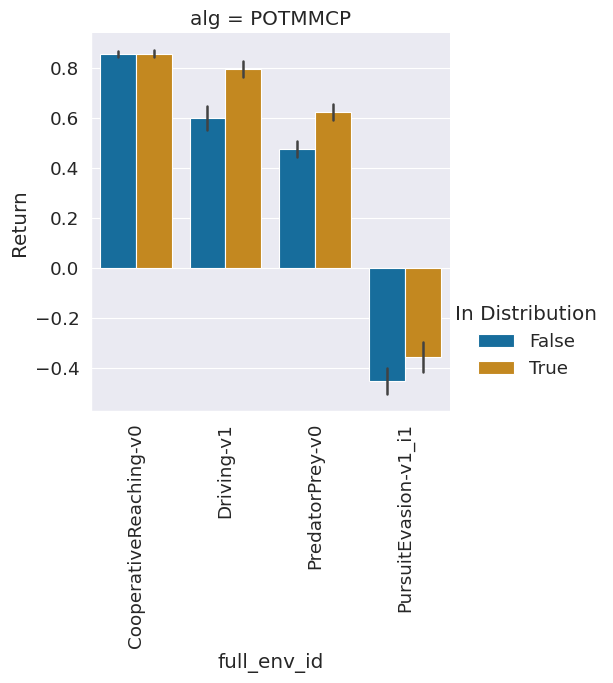

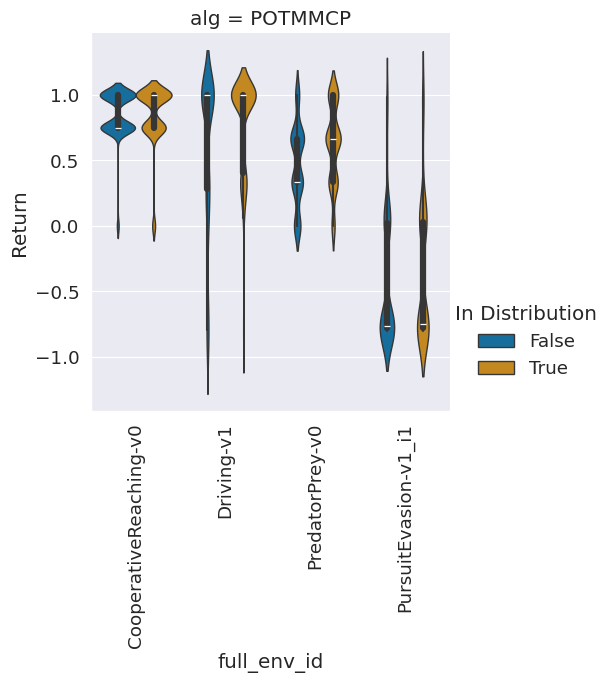

In [28]:
for kind in ("bar", "violin"):
    plot = sns.catplot(
        data=planning_results_df[
            planning_results_df["search_time_limit"] == max_search_time
        ],
        x="full_env_id",
        y="Return",
        hue="In Distribution",
        col="alg",
        # col_wrap=N_COLS,
        # row="alg",
        kind=kind,
        sharey=False,
    )
    plot.set_xticklabels(rotation=90)

    if SAVE_RESULTS:
        plot.figure.savefig(
            osp.join(
                exp_utils.ENV_DATA_DIR, 
                f"planning_id_vs_ood_by_env_results_{kind}.png"
            ), 
            bbox_inches="tight"
        )

    del plot

## In vs Out of Distribution Performance vs Search Time

Here we look at the in vs out of distribution performance of each algorithm across search budgets, averaged across environments.

- `x-axis`: Search time
- `y-axis`: Mean episode return
- `hue/z-axis`: In (True) vs Out (False) of Distribution
- `col/figures`: Algorithm

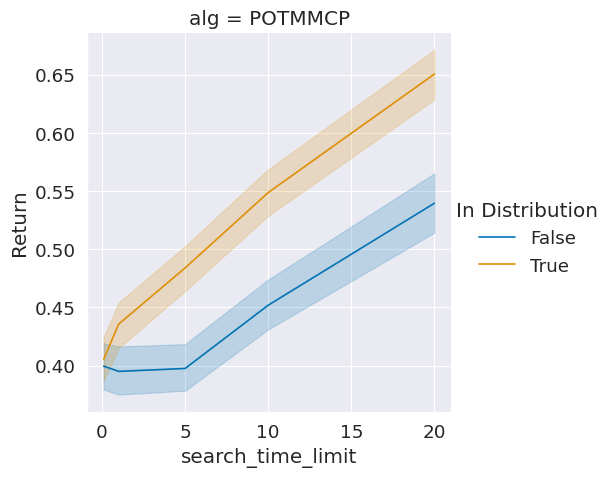

In [22]:
plot = sns.relplot(
    data=planning_results_df,
    x="search_time_limit",
    y="Return",
    hue="In Distribution",
    col="alg",
    # col_wrap=N_COLS,
    # row="alg",
    kind="line",
)

if SAVE_RESULTS:
    plot.figure.savefig(
        exp_utils.ENV_DATA_DIR / "planning_id_vs_ood_by_search_time_per_alg.png",
        bbox_inches="tight"
    )

del plot

Here we show a similar plot except each line represents a different algorithm and each figure is In vs Out of Distribution performance.

- `x-axis`: Search time
- `y-axis`: Mean episode return
- `hue/z-axis`: Algorithm
- `col/figures`: In (True) vs Out (False) of Distribution

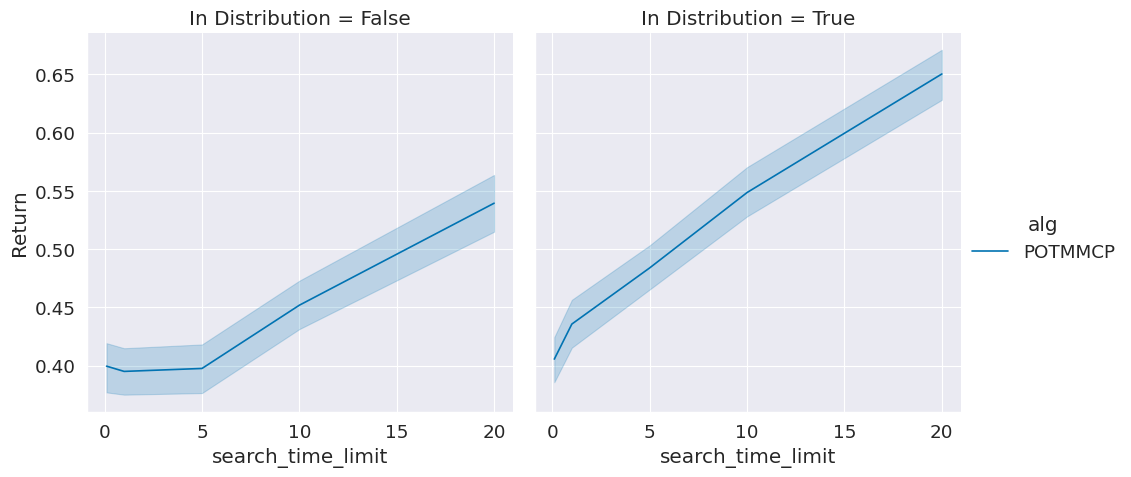

In [23]:
plot = sns.relplot(
    data=planning_results_df,
    x="search_time_limit",
    y="Return",
    hue="alg",
    col="In Distribution",
    # col_wrap=N_COLS,
    # row="alg",
    kind="line",
)

if SAVE_RESULTS:
    plot.figure.savefig(
        exp_utils.ENV_DATA_DIR / "planning_id_vs_ood_by_search_time_alg_compare.png", 
        bbox_inches="tight"
    )

del plot

## Search Statistics

Here we look at various statistics of the search process for each algorithm.

Each figure is a different statistic, and each line is a different algorithm. The hue is the environment since we expect some differences between environments based on things like average steps to terminal state. In and out of distribution results are grouped together since we expect and see no different in search statistics between in vs out of distribution.

- `x-axis`: Search time
- `y-axis`: Search Statistic Values
- `hue/z-axis`: Algorithm
- `col/figures`: Environment

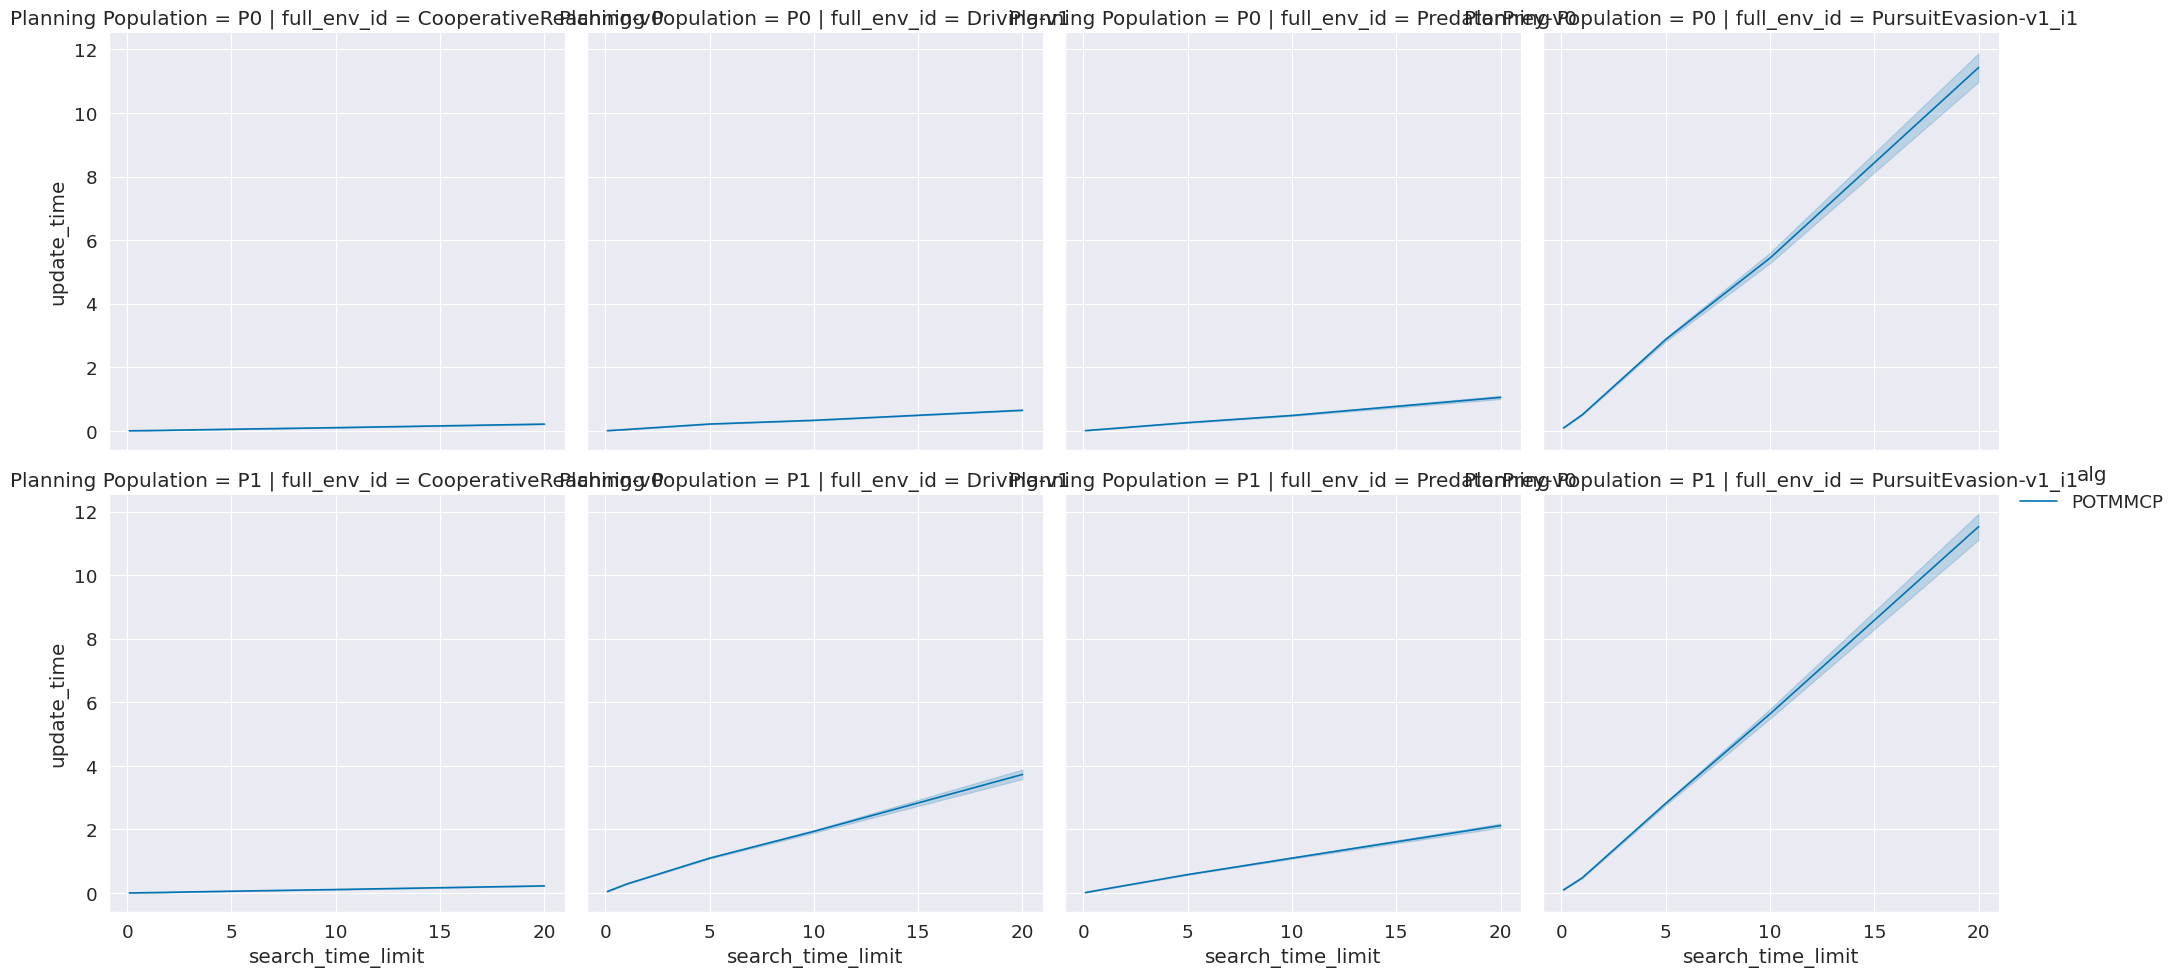

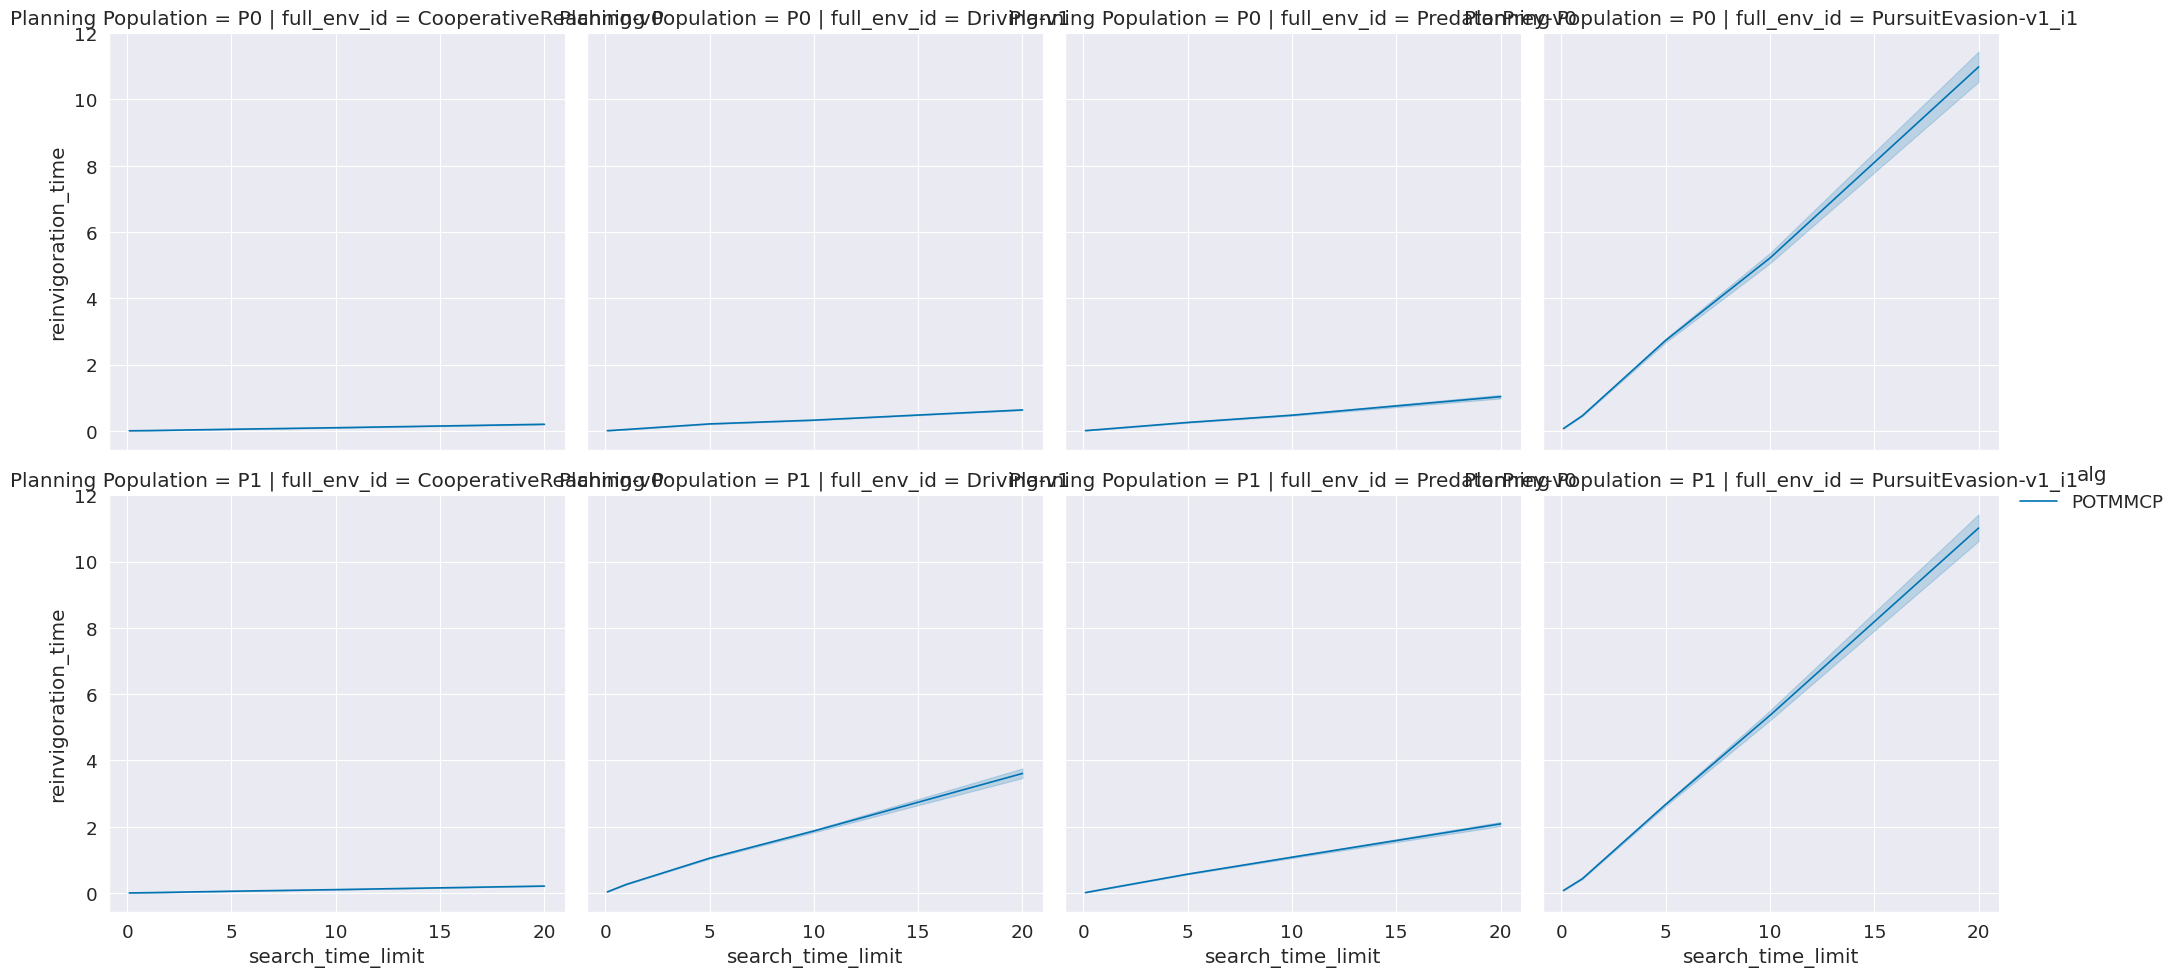

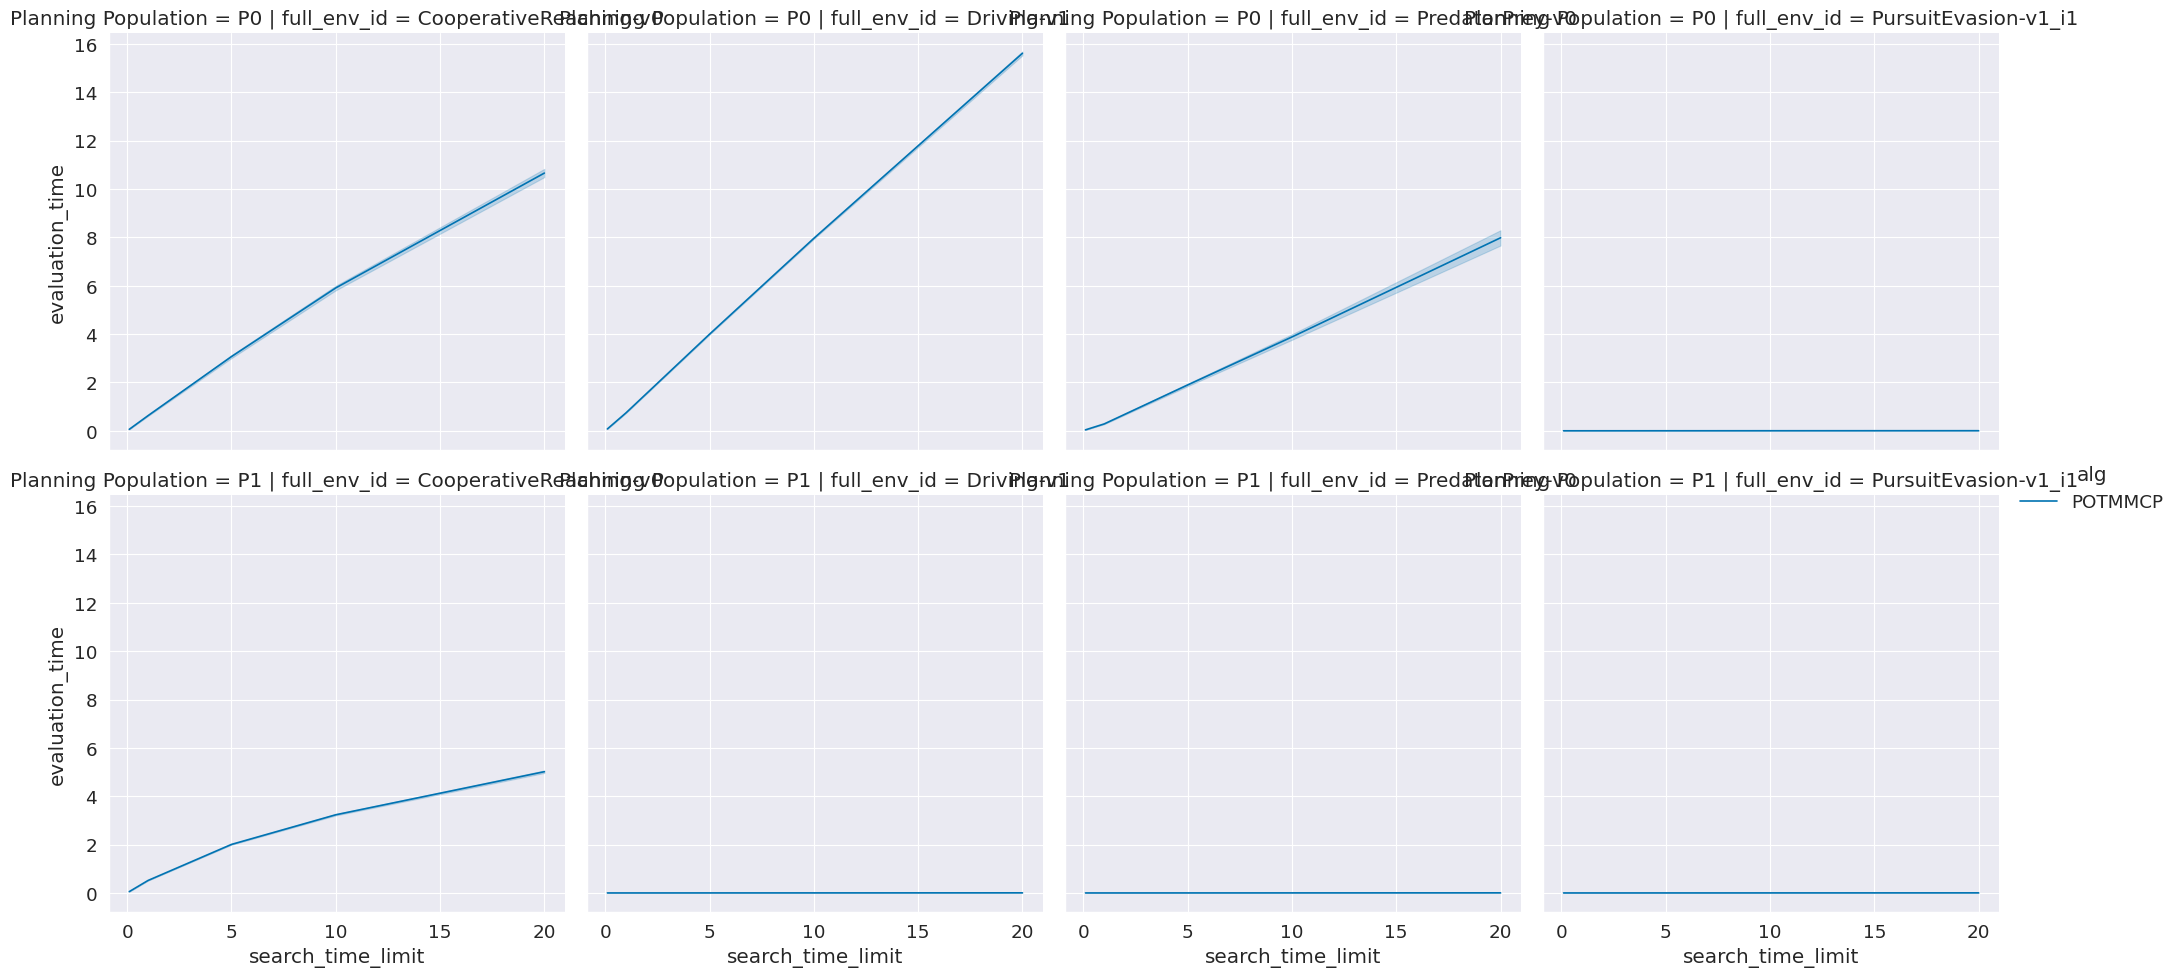

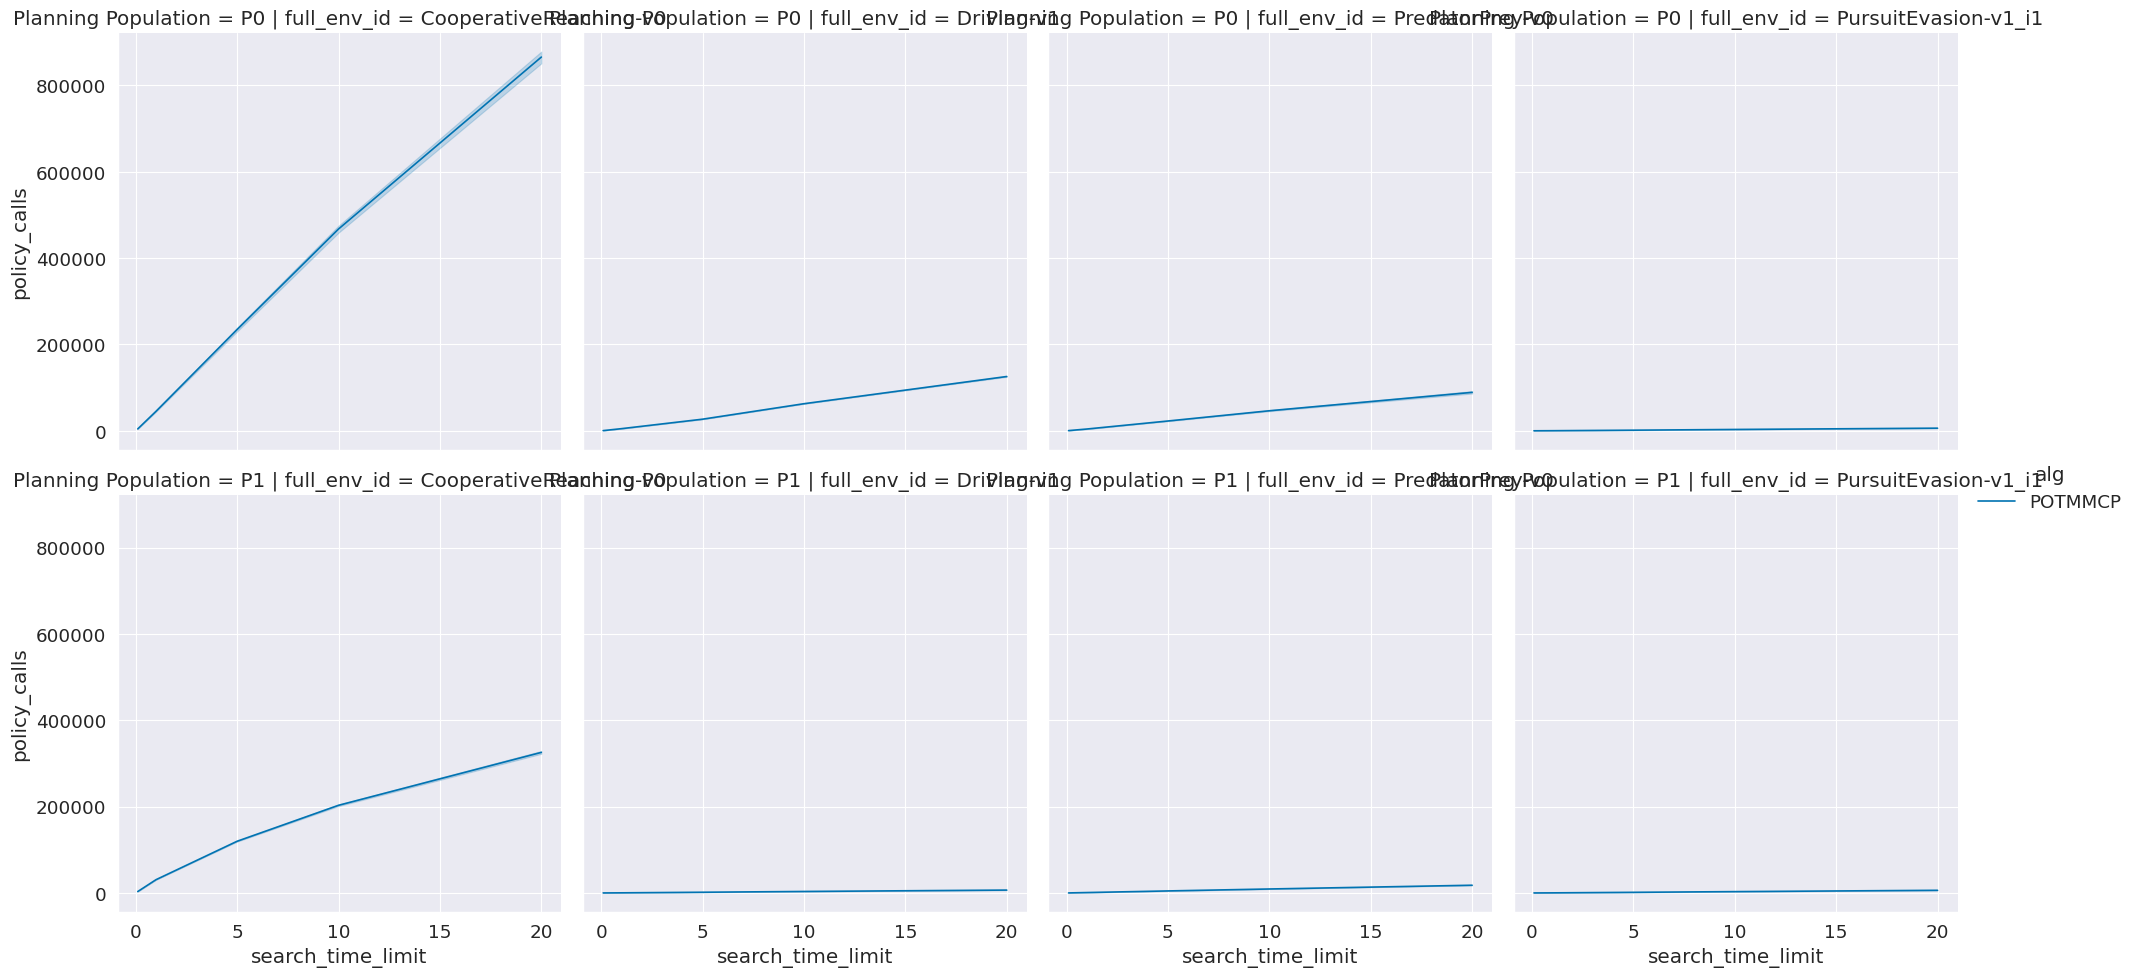

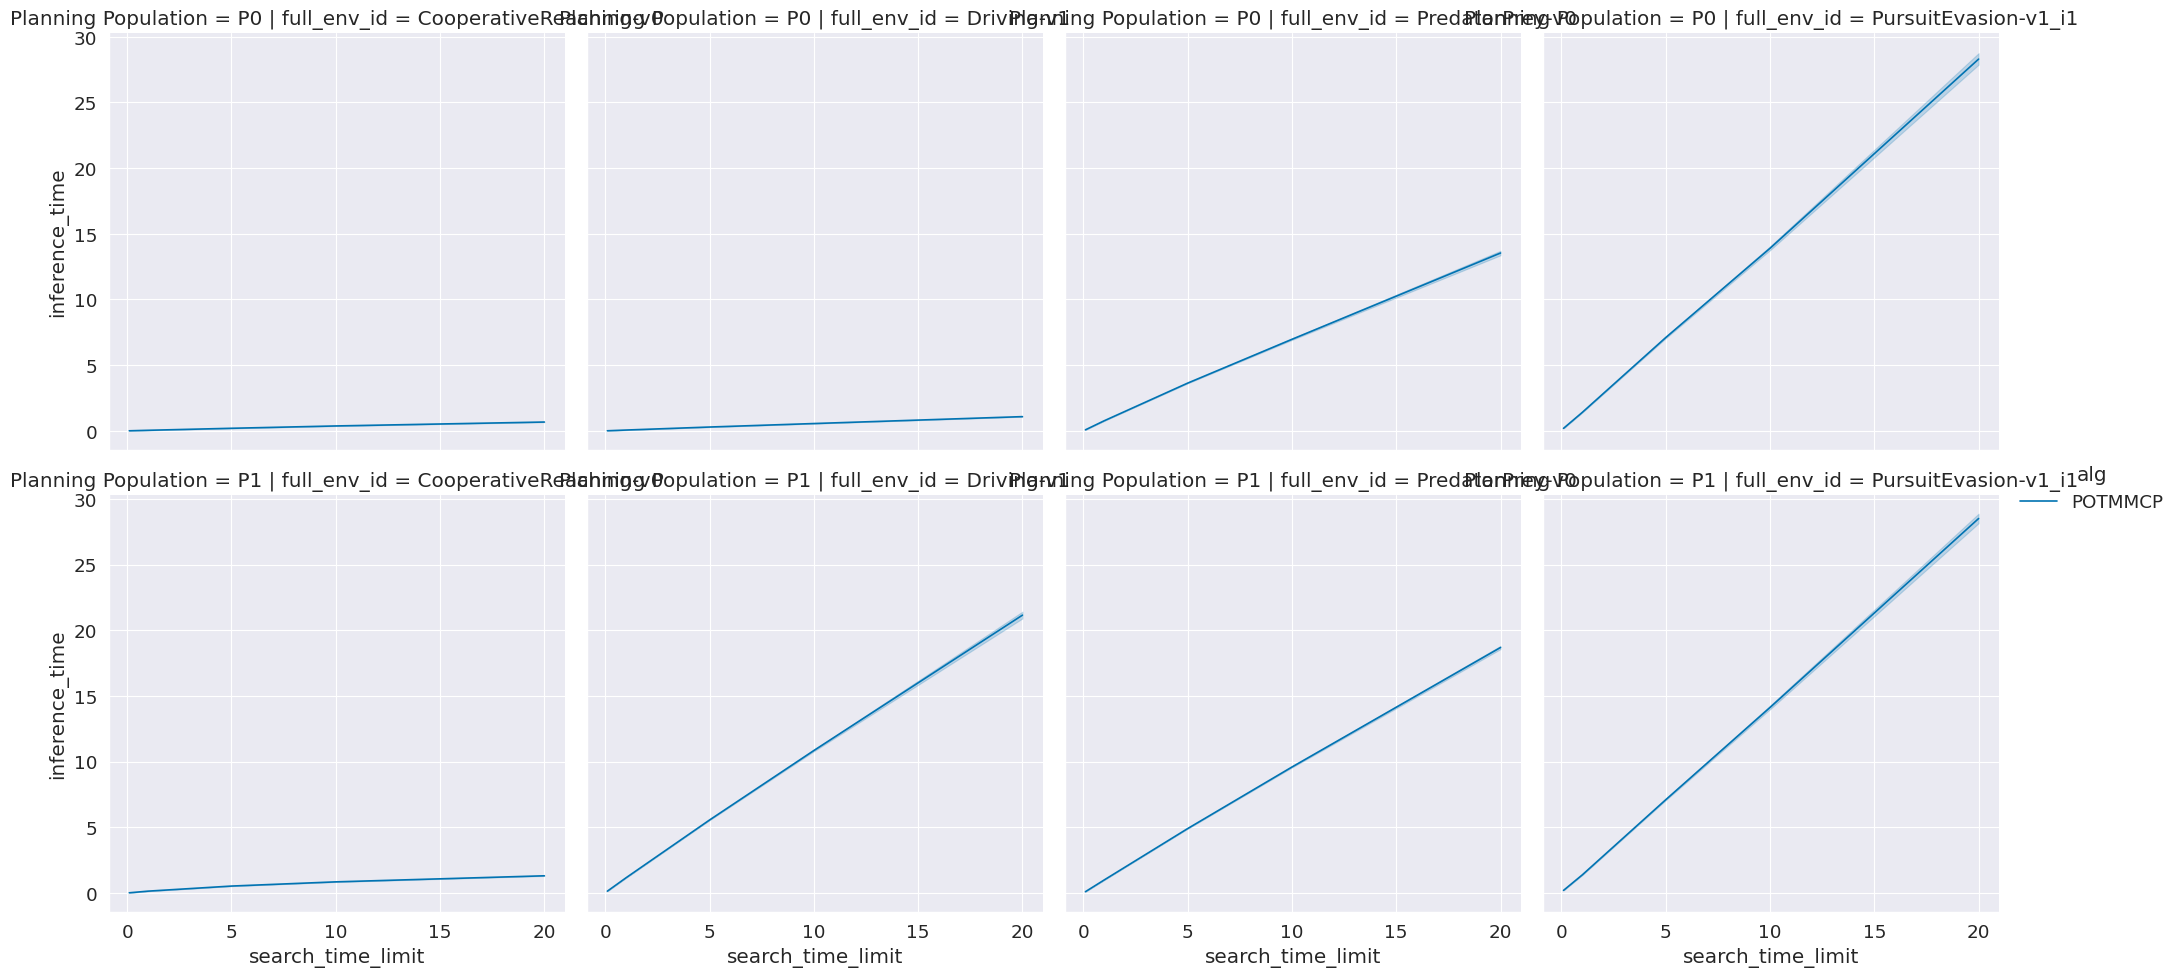

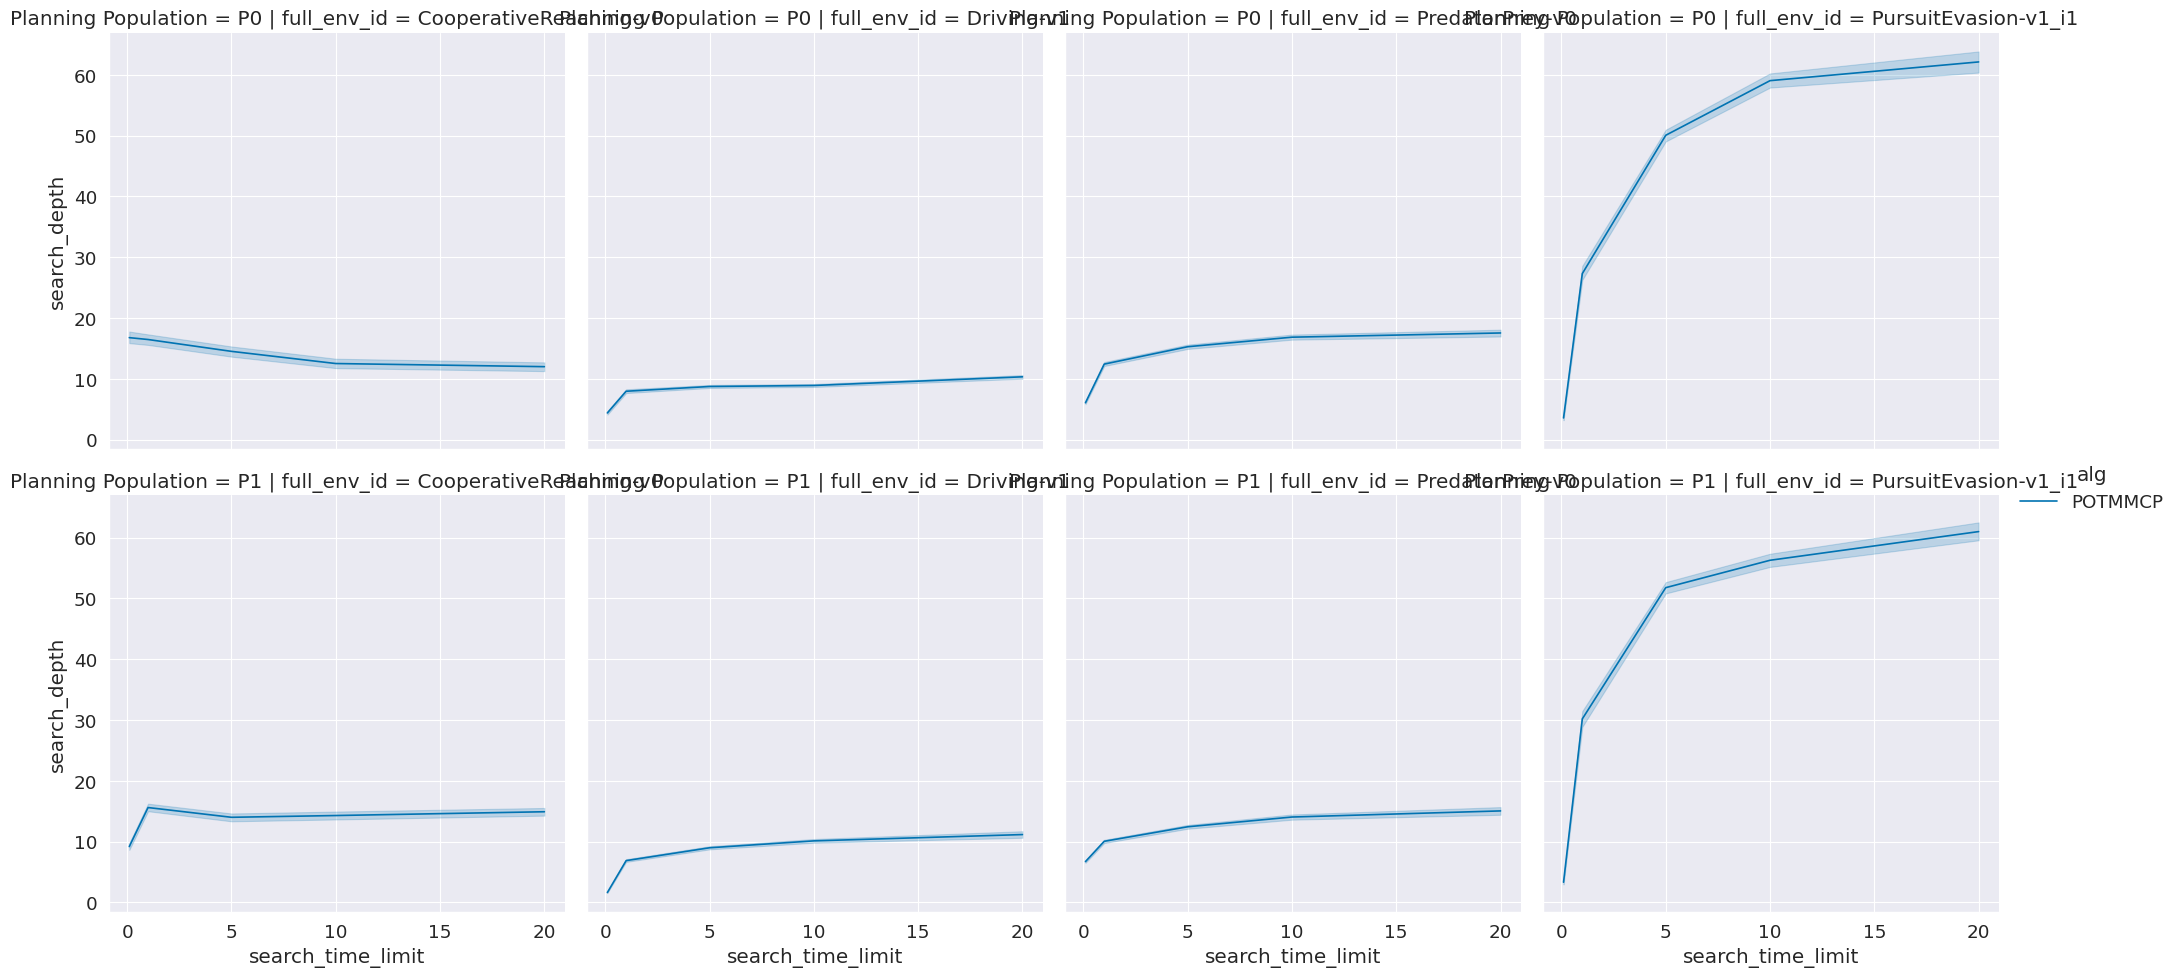

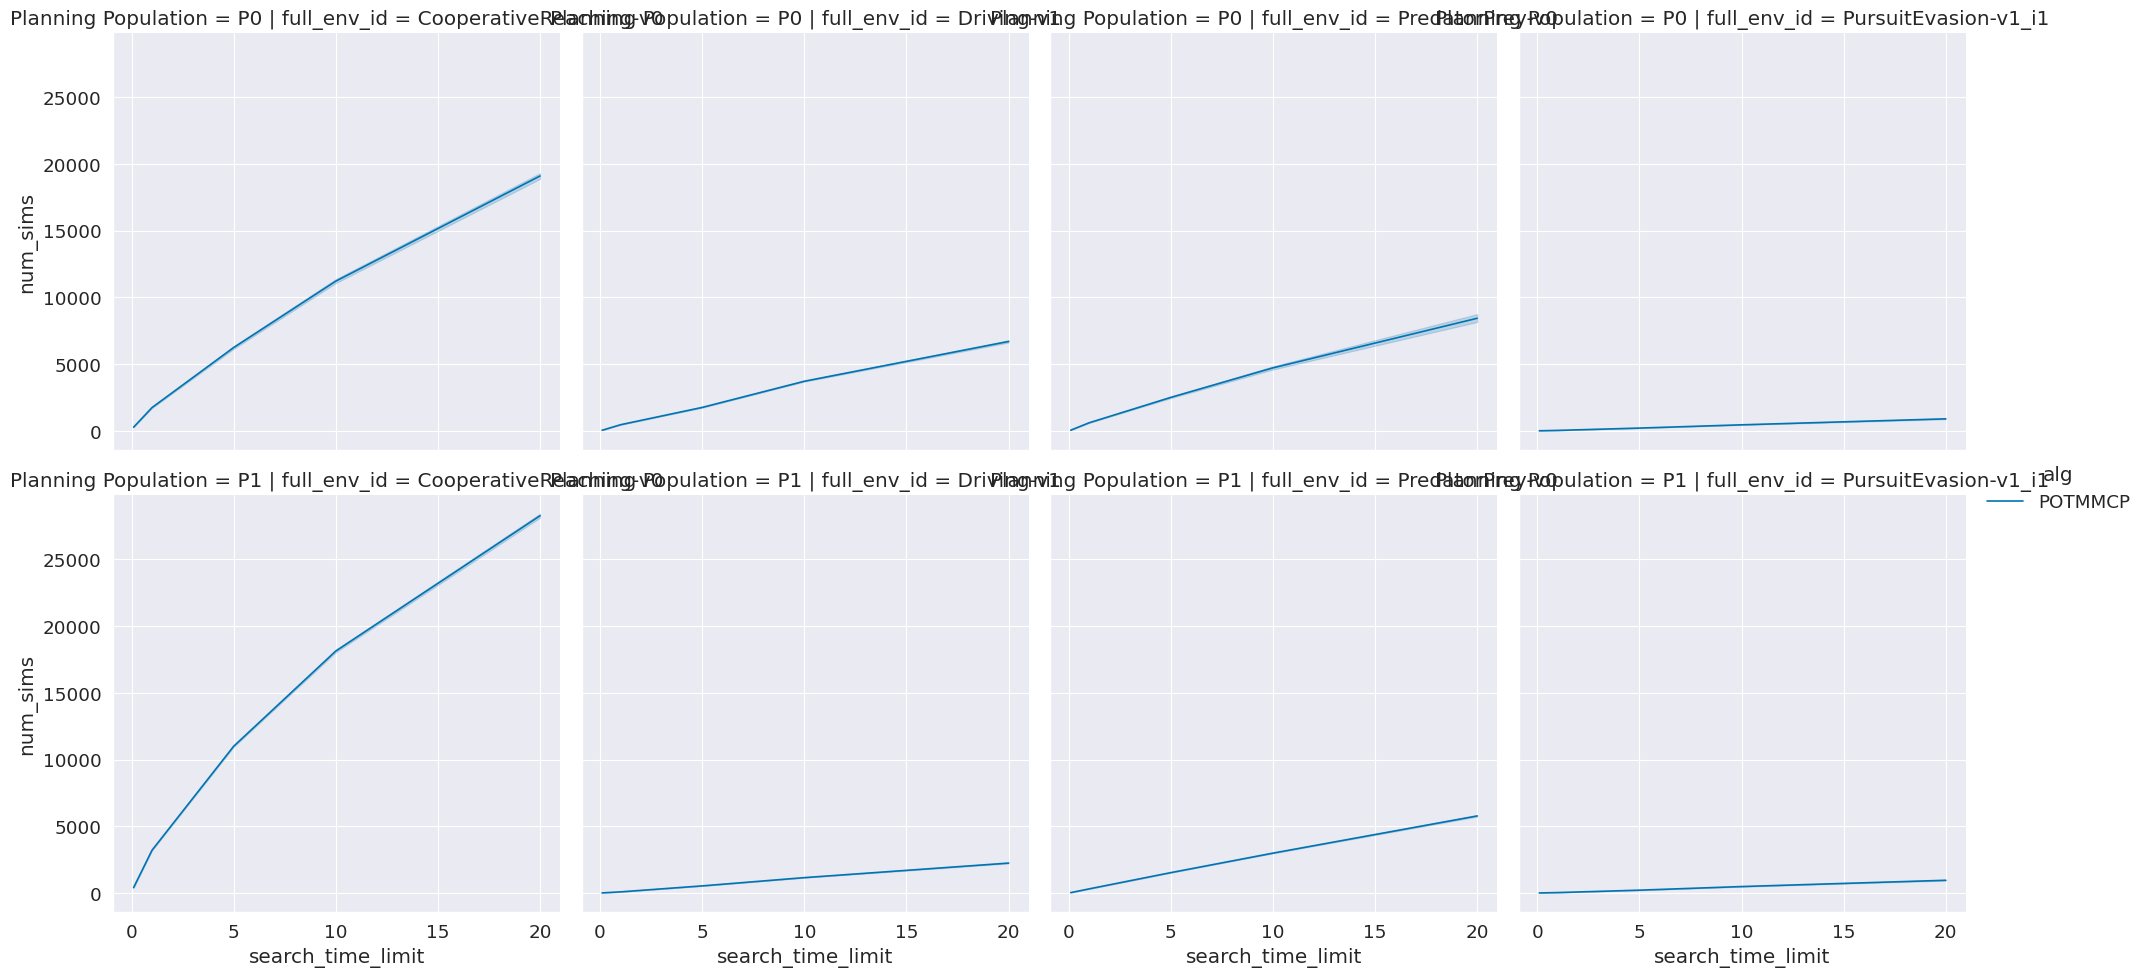

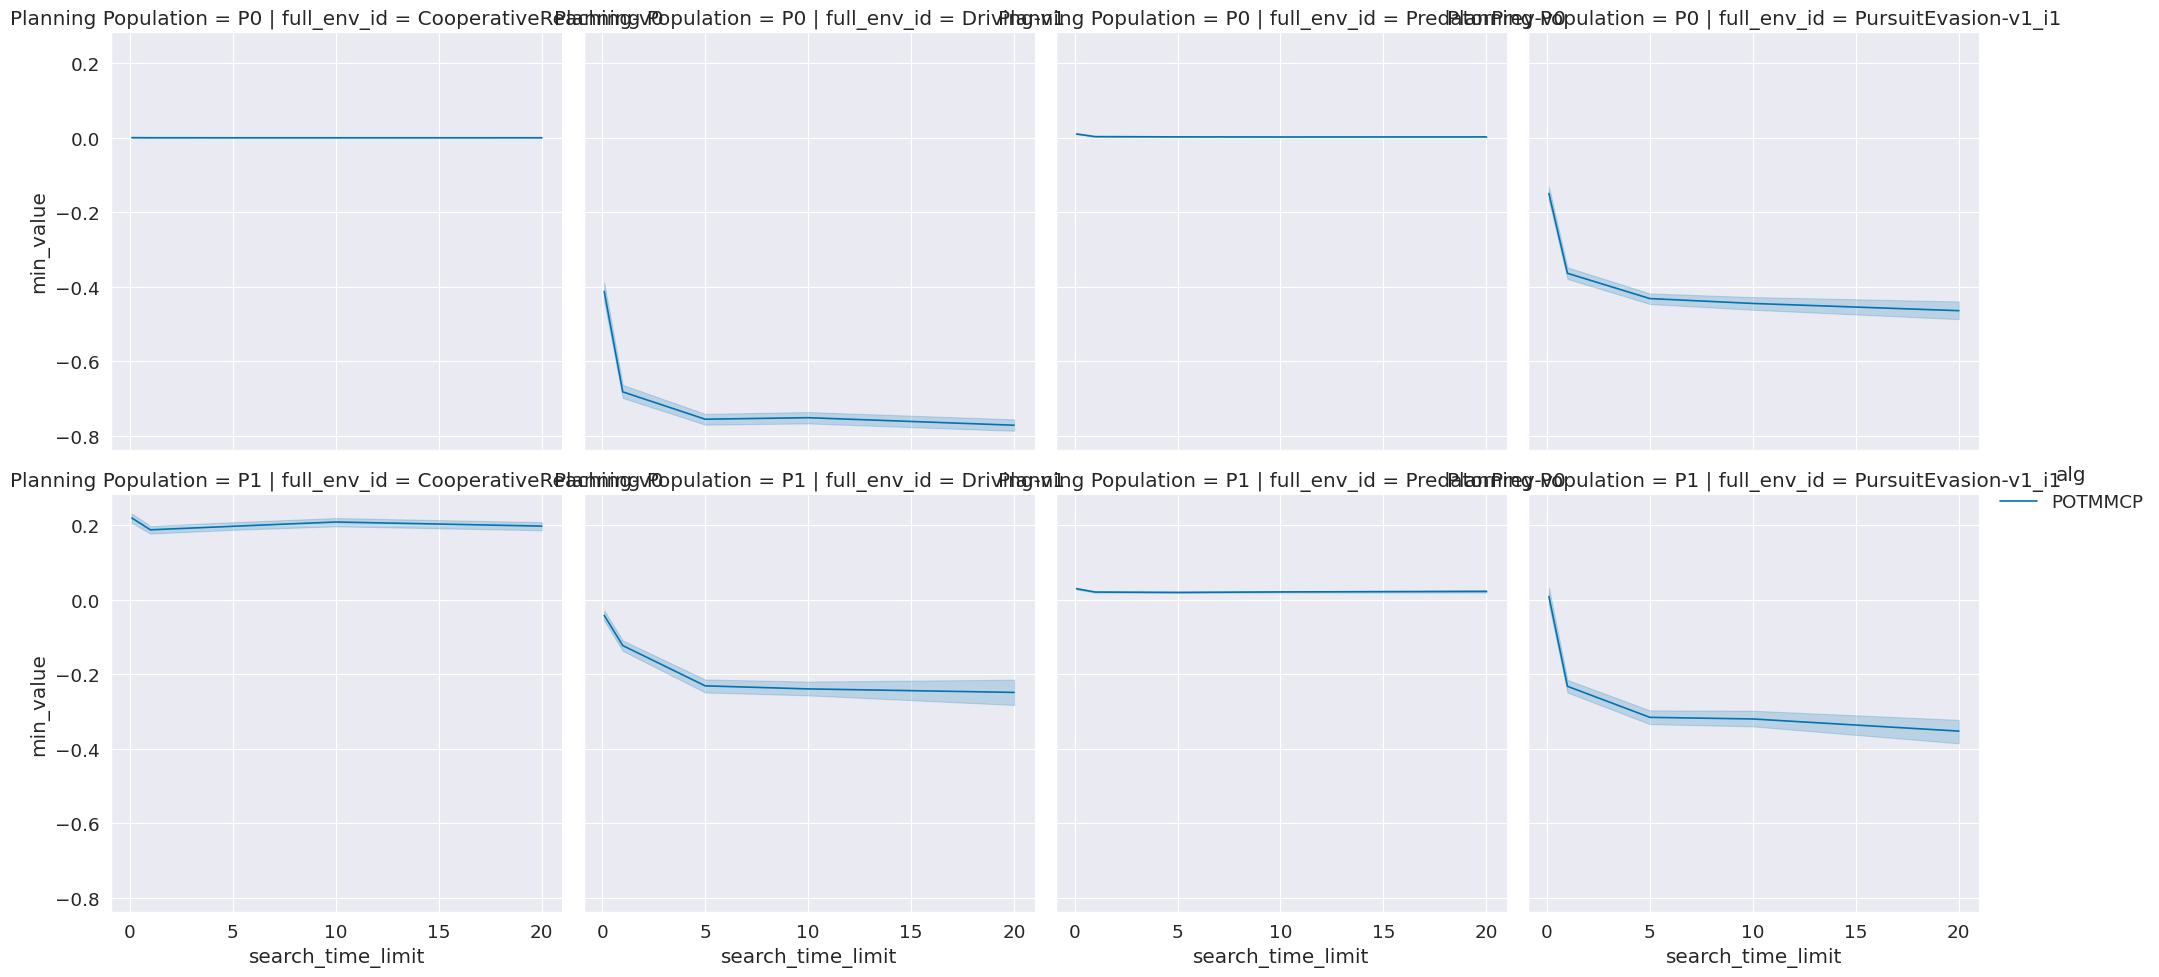

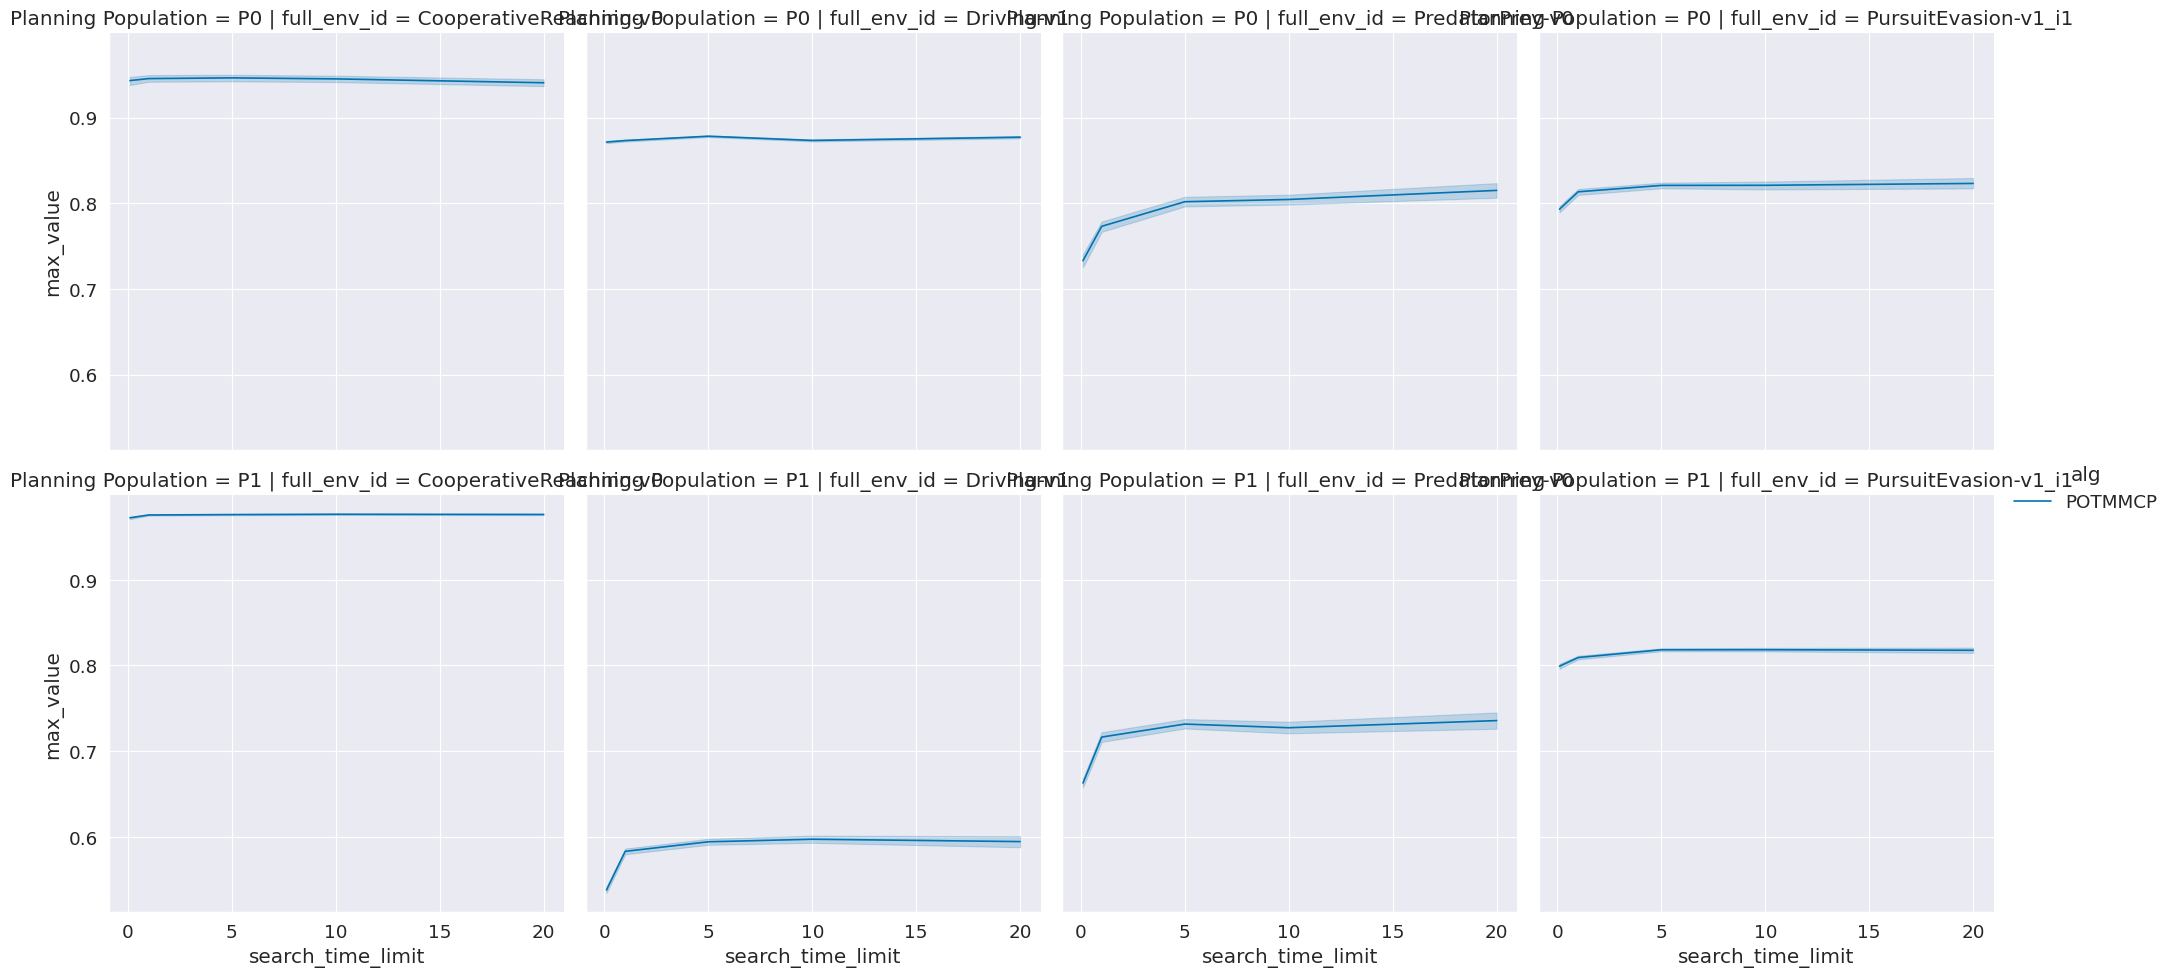

In [25]:
for stat_key in [
    "update_time",
    "reinvigoration_time",
    "evaluation_time",
    "policy_calls",
    "inference_time",
    "search_depth",
    "num_sims",
    "min_value",
    "max_value",
]:

    plot = sns.relplot(
        data=planning_results_df,
        x="search_time_limit",
        y=stat_key,
        hue="alg",
        col="full_env_id",
        # col_wrap=N_COLS,
        kind="line",
        row="Planning Population",
    )

    if SAVE_RESULTS:
        plot.figure.savefig(
            osp.join(
                exp_utils.ENV_DATA_DIR, 
                f"planning_{stat_key}.png"
            ), 
            bbox_inches="tight"
        )

    del plot